In [1]:
!pip install torch_geometric
!pip install rdkit
!pip install umap-learn
!pip install hdbscan
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 19.4 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader

from data_loaders import preproccess_data, generate_scaffold_split, df_to_graph_list, get_scaffolds
from gcn import GCN

from sklearn.metrics import r2_score
import numpy as np
import scipy.stats as stats

from torch.optim.lr_scheduler import CosineAnnealingLR

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import toml

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
file_path = '/content/drive/MyDrive/BioSolveAI/data/curated-solubility-dataset.csv'
df = preproccess_data(file_path)


df['scaffold'] = df['mol'].apply(get_scaffolds)

# scaffolds to get train, val, text
train_idx, val_idx, test_idx = generate_scaffold_split(df)

# Split the dataframe into train, val, and test
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]
test_df = df.iloc[test_idx]

# df to graph list
train_graph_list = df_to_graph_list(train_df)
val_graph_list = df_to_graph_list(val_df)
test_graph_list = df_to_graph_list(test_df)

In [6]:
config = toml.load("config.toml")

# access the parameters
batch_size = config["BATCH_SIZE"]
epochs = config["EPOCHS"]
learning_rate = config["LEARNING_RATE"]
weight_decay = config["WEIGHT_DECAY"]

print("Batch size:", batch_size)
print("Epochs:", epochs)
print("Learning rate:", learning_rate)
print("Weight decay:", weight_decay)

Batch size: 32
Epochs: 60
Learning rate: 0.0008935532131641973
Weight decay: 0.006955968863499973


In [7]:
train_loader = DataLoader(train_graph_list, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_graph_list, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_graph_list, batch_size=batch_size, shuffle=False)

Epoch: 1, Train Loss: 1.2104, Val Loss: 0.4014
Epoch: 2, Train Loss: 0.6807, Val Loss: 0.3724
Epoch: 3, Train Loss: 0.5871, Val Loss: 0.3884
Epoch: 4, Train Loss: 0.5491, Val Loss: 0.3539
Epoch: 5, Train Loss: 0.5069, Val Loss: 0.3237
Epoch: 6, Train Loss: 0.4915, Val Loss: 0.3342
Epoch: 7, Train Loss: 0.4645, Val Loss: 0.2964
Epoch: 8, Train Loss: 0.4619, Val Loss: 0.3106
Epoch: 9, Train Loss: 0.4424, Val Loss: 0.2948
Epoch: 10, Train Loss: 0.4277, Val Loss: 0.2761
Epoch: 11, Train Loss: 0.4142, Val Loss: 0.2631
Epoch: 12, Train Loss: 0.4106, Val Loss: 0.2538
Epoch: 13, Train Loss: 0.4004, Val Loss: 0.2760
Epoch: 14, Train Loss: 0.3916, Val Loss: 0.2529
Epoch: 15, Train Loss: 0.3854, Val Loss: 0.2559
Epoch: 16, Train Loss: 0.3749, Val Loss: 0.2546
Epoch: 17, Train Loss: 0.3717, Val Loss: 0.2526
Epoch: 18, Train Loss: 0.3638, Val Loss: 0.2486
Epoch: 19, Train Loss: 0.3620, Val Loss: 0.2380
Epoch: 20, Train Loss: 0.3550, Val Loss: 0.2316
Epoch: 21, Train Loss: 0.3506, Val Loss: 0.2578
E

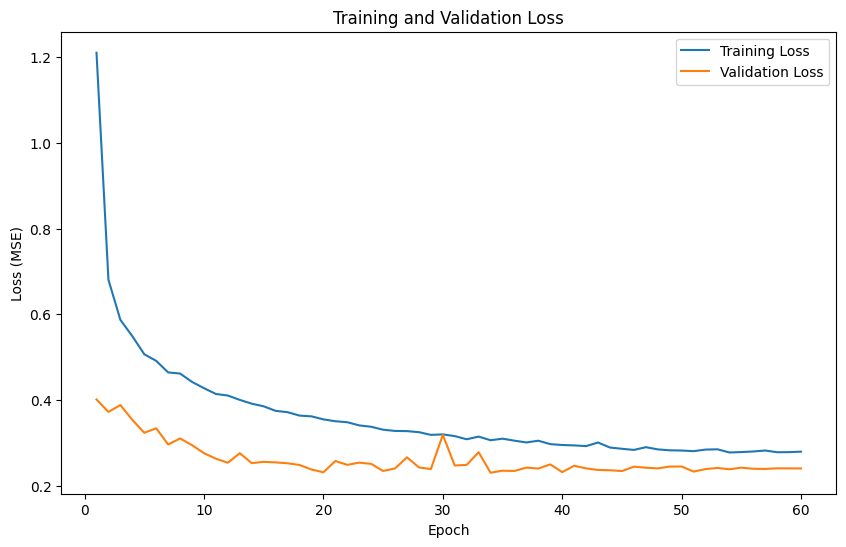

In [8]:
from train_utils import plot_losses, train, evaluate_model

num_node_dim = train_graph_list[0].x.shape[1]
edge_attr_dim = train_graph_list[0].edge_attr.shape[1]
u_dim = train_graph_list[0].u.shape[1]

# init model
model = GCN(num_node_features=num_node_dim,
            edge_attr_dim=edge_attr_dim,
            u_dim=u_dim,
            hidden_dim=64,
            output_dim=1).to(device)

train(model, train_loader, val_loader, epochs, learning_rate, weight_decay, device);


In [9]:
evaluate_model(model, test_loader, device);

Test RMSE: 0.4263 with 95% CI: [0.4023, 0.4491]
Test R²: 0.7272 with 95% CI: [0.6919, 0.7614]
